Creating proxy 'Day' column for group splitting...

   TUNING WEAKENED RANDOM FOREST (GROUP SPLIT)
1. Training Base Model (Physics)...
   > Base Model Train MAE: 6.27 MPa

2. Training Correction Model...
   > Training on 9 unique days.
   > Testing on 3 unique days (unseen).
   > Running Grid Search to find robust parameters...
   > Best Settings: {'max_depth': 1, 'max_samples': 0.5, 'min_samples_leaf': 30, 'n_estimators': 100}

3. Validating Full System...
   > FINAL MAE (Group Validated): 2.05 MPa


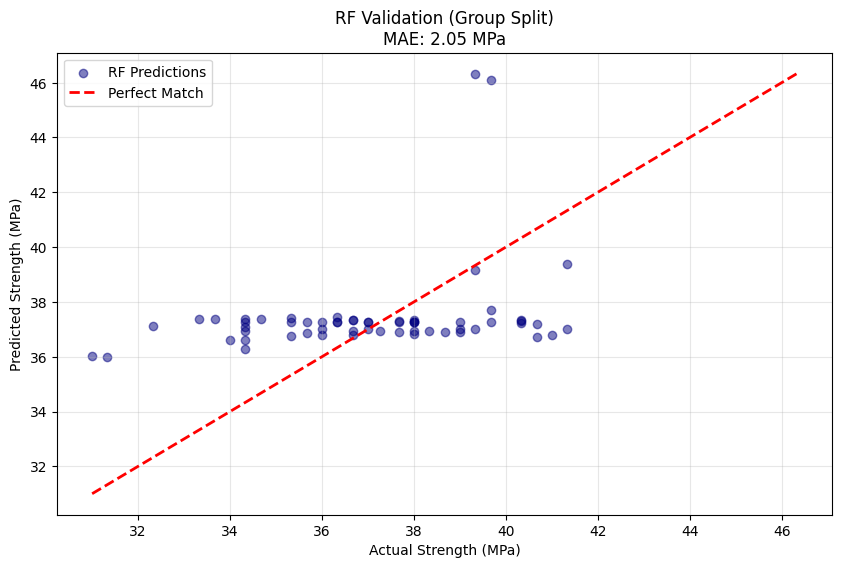

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit
from sklearn.metrics import mean_absolute_error

df_kaggle = pd.read_csv("Data/zainfaisal_pakistan_concrete_data.csv")
df_local = pd.read_csv("Data/localdataset.csv")

# --- 1. HELPER FUNCTION (Standard Random Forest) ---
# (This remains unchanged as it prepares the "Lab" data structure)
def train_helper_data(df):
    recipe_cols = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 
                   'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate']
    df.columns = df.columns.str.strip() 
    
    # Train Helper on actual 7-day data
    df_7 = df[df['Age'] == 7].copy()
    X_helper = df_7[recipe_cols]
    y_helper = df_7['Strength']
    
    helper_model = RandomForestRegressor(n_estimators=100, random_state=42)
    helper_model.fit(X_helper, y_helper)

    # Impute 7-day strength for 28-day rows
    df_28 = df[df['Age'] == 28].copy()
    df_28['Predicted_Strength_7'] = helper_model.predict(df_28[recipe_cols])
    
    # Merge real 7-day data where available
    df_7_grouped = df_7.groupby(recipe_cols)['Strength'].mean().reset_index()
    df_7_grouped = df_7_grouped.rename(columns={'Strength': 'Real_Strength_7'})
    
    df_augmented = pd.merge(df_28, df_7_grouped, on=recipe_cols, how='left')
    df_augmented['Strength_7'] = df_augmented['Real_Strength_7'].fillna(df_augmented['Predicted_Strength_7'])
    
    final_dataset = df_augmented[['Strength_7', 'Strength']].copy().rename(columns={'Strength': 'Strength_28'})
    return final_dataset

# --- 2. FIXED WEAKENED RANDOM FOREST PIPELINE (With Group Splitting) ---
def process_weakened_random_forest_fixed(df_helper, df_local, group_col='Day'):
    print("\n" + "="*50)
    print("   TUNING WEAKENED RANDOM FOREST (GROUP SPLIT)")
    print("="*50)

    # --- Step A: TRAIN BASE MODEL (The "Lab Curve") ---
    print("1. Training Base Model (Physics)...")
    X_base = df_helper[['Strength_7']]
    y_base = df_helper['Strength_28']
    
    # Base model remains standard to learn the strong chemical relationship
    base_model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)
    base_model.fit(X_base, y_base)
    
    # Validate Base Model briefly
    base_preds = base_model.predict(X_base)
    print(f"   > Base Model Train MAE: {mean_absolute_error(y_base, base_preds):.2f} MPa")

    # --- Step B: TRAIN CORRECTION MODEL (Temp + Rainfall) ---
    print("\n2. Training Correction Model...")
    
    # 1. Calculate Residuals (What the physics model missed)
    # We use .copy() to ensure we don't modify the original dataframe slice
    df_work = df_local.copy()
    df_work['Base_Pred_Lab'] = base_model.predict(df_work[['Strength_7']])
    df_work['Residual'] = df_work['Strength_28'] - df_work['Base_Pred_Lab']
    
    features = ['avgTemp', 'Rainfall_Code']
    target = 'Residual'
    
    # 2. GROUP SPLIT (The Fix)
    # This splits the data by 'Day' (or batch) so test data is from completely unseen days.
    # If the model memorizes a day's weather, it will fail here (which is what we want to detect).
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(splitter.split(df_work, groups=df_work[group_col]))
    
    X_train_c = df_work.iloc[train_idx][features]
    y_train_c = df_work.iloc[train_idx][target]
    
    # We keep the full rows for validation later to access Strength_7 easily
    test_rows = df_work.iloc[test_idx]
    
    print(f"   > Training on {len(df_work.iloc[train_idx][group_col].unique())} unique days.")
    print(f"   > Testing on {len(df_work.iloc[test_idx][group_col].unique())} unique days (unseen).")

    # 3. WEAKENING GRID SEARCH
    # We force the model to be simple so it generalizes instead of memorizing.
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [1, 2],           # Very shallow trees (prevents overfitting)
        'min_samples_leaf': [20, 30],  # High number required to make a rule
        'max_samples': [0.5, 0.7]      # Randomness
    }
    
    print("   > Running Grid Search to find robust parameters...")
    rf_search = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    rf_search.fit(X_train_c, y_train_c)
    
    correction_model = rf_search.best_estimator_
    print(f"   > Best Settings: {rf_search.best_params_}")

    # --- Step C: VALIDATION ---
    print("\n3. Validating Full System...")
    
    # 1. Base Prediction (Physics) on Test Set
    pred_base_test = base_model.predict(test_rows[['Strength_7']])
    
    # 2. Correction Prediction (Environment) on Test Set
    pred_corr_test = correction_model.predict(test_rows[features])
    
    # 3. Combine
    final_predictions = pred_base_test + pred_corr_test
    actual_values = test_rows['Strength_28']
    
    final_mae = mean_absolute_error(actual_values, final_predictions)
    print(f"   > FINAL MAE (Group Validated): {final_mae:.2f} MPa")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, final_predictions, color='navy', alpha=0.5, label='RF Predictions')
    
    # Plot perfect fit line
    min_val = min(min(actual_values), min(final_predictions))
    max_val = max(max(actual_values), max(final_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match')
    
    plt.xlabel("Actual Strength (MPa)")
    plt.ylabel("Predicted Strength (MPa)")
    plt.title(f"RF Validation (Group Split)\nMAE: {final_mae:.2f} MPa")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return base_model, correction_model

# --- 3. EXECUTION ---

# Note: Assuming 'df_kaggle' and 'df_local' are already loaded in your environment 
# as per your previous code cells.

# 1. Prepare Helper Data (Lab curve data)
df_helper = train_helper_data(df_kaggle)

# 2. Prepare Local Data (Ensure we have a Group Column)
# If 'df_local' does not have a 'Day' column, we create a proxy one.
# Concrete data is often sequential. If you have blocks of 20 samples per day:
if 'Day' not in df_local.columns:
    print("Creating proxy 'Day' column for group splitting...")
    samples_per_day = 20  # Adjust this if you know the specific batch size
    df_local['Day'] = df_local.index // samples_per_day

# 3. Run the Fixed Pipeline
base_model_rf, correction_model_rf = process_weakened_random_forest_fixed(df_helper, df_local, group_col='Day')